> ### EEE4423: Signal Processing Lab

# LAB \#3: CNN: VGG Net and ResNet [CoLab]

<h4><div style="text-align: right"> Due date: April 7, 2020.  </div> <br>
<div style="text-align: right"> Please upload your file @ yscec by 2 PM in the form of [ID_Name_Lab3.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2015142116] [제강민]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2020-04-04 07:45:15.736472


In [2]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above. 
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)

OS information
Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic

Is GPU available?
True

GPU information
Sat Apr  4 07:45:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                    

## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1OiTmrplD9gOrEJizLChyLp31R0QtoeHv" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1bBvAOdJeskMMyOrZtBCCnkEEgq9PgjX9" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10/


In [0]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [6]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [7]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

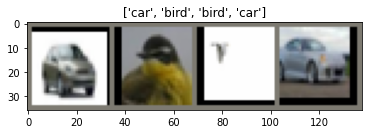

In [10]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=4, 
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

#############
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # Convolution 1
        self.cnn1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1_1 = nn.ReLU()
        self.bn1_1 = nn.BatchNorm2d(64)

        self.cnn1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1_2 = nn.ReLU()
        self.bn1_2 = nn.BatchNorm2d(64)

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Convolution 2
        self.cnn2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2_1 = nn.ReLU()
        self.bn2_1 = nn.BatchNorm2d(128)

        self.cnn2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2_2 = nn.ReLU()
        self.bn2_2 = nn.BatchNorm2d(128)

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Convolution 3
        self.cnn3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu3_1 = nn.ReLU()
        self.bn3_1 = nn.BatchNorm2d(256)

        self.cnn3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu3_2 = nn.ReLU()
        self.bn3_2 = nn.BatchNorm2d(256)

        self.cnn3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu3_3 = nn.ReLU()
        self.bn3_3 = nn.BatchNorm2d(256)

        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        # Convolution 4
        self.cnn4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.relu4_1 = nn.ReLU()
        self.bn4_1 = nn.BatchNorm2d(512)

        self.cnn4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.relu4_2 = nn.ReLU()
        self.bn4_2 = nn.BatchNorm2d(512)

        self.cnn4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.relu4_3 = nn.ReLU()
        self.bn4_3 = nn.BatchNorm2d(512)

        # Max pool 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        # Convolution 5
        self.cnn5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.relu5_1 = nn.ReLU()
        self.bn5_1 = nn.BatchNorm2d(512)

        self.cnn5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.relu5_2 = nn.ReLU()
        self.bn5_2 = nn.BatchNorm2d(512)

        self.cnn5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.relu5_3 = nn.ReLU()
        self.bn5_3 = nn.BatchNorm2d(512)

        # Max pool 5
        self.maxpool5 = nn.MaxPool2d(kernel_size=2)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(512, 10)

    def forward(self, x):

        # Conv layer 1-max pool
        out = self.cnn1_1(x)
        out = self.relu1_1(out)
        out = self.bn1_1(out)
        out = self.cnn1_2(out)
        out = self.relu1_2(out)
        out = self.bn1_2(out)
        out = self.maxpool1(out)

        # Conv layer 2-max pool
        out = self.cnn2_1(out)
        out = self.relu2_1(out)
        out = self.bn2_1(out)
        out = self.cnn2_2(out)
        out = self.relu2_2(out)
        out = self.bn2_2(out)
        out = self.maxpool2(out)

        # Conv layer 3-max pool
        out = self.cnn3_1(out)
        out = self.relu3_1(out)
        out = self.bn3_1(out)
        out = self.cnn3_2(out)
        out = self.relu3_2(out)
        out = self.bn3_2(out)
        out = self.cnn3_3(out)
        out = self.relu3_3(out)
        out = self.bn3_3(out)
        out = self.maxpool3(out)

        # Conv layer 4-max pool
        out = self.cnn4_1(out)
        out = self.relu4_1(out)
        out = self.bn4_1(out)
        out = self.cnn4_2(out)
        out = self.relu4_2(out)
        out = self.bn4_2(out)
        out = self.cnn4_3(out)
        out = self.relu4_3(out)
        out = self.bn4_3(out)
        out = self.maxpool4(out)

        # Conv layer 5-max pool
        out = self.cnn5_1(out)
        out = self.relu5_1(out)
        out = self.bn5_1(out)
        out = self.cnn5_2(out)
        out = self.relu5_2(out)
        out = self.bn5_2(out)
        out = self.cnn5_3(out)
        out = self.relu5_3(out)
        out = self.bn5_3(out)
        out = self.maxpool5(out)

        # Resize
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out
#############



STEP 3: CREATE MODEL CLASS (VGG16)


### 1.1 Write code (VGG 16) [3 points]

In [12]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  14728266


VGG(
  (cnn1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(

In [13]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [14]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

#############
iter = 0
for epoch in range(num_epochs):

    t0 = time.time()
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

    t1 = time.time()

    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:
            
        images = images.to(device)
        labels = labels.to(device)
               
        # Forward pass only to get logits/output
        outputs = model(images) # output size = (batch_size, 10)
                
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
 
    # Print Loss
    print('Epochs: {}. Loss: {}. Accuracy: {}. Elapsed Time: {} sec'.format(epoch, loss.item(), accuracy, t1 - t0))
#############



STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.4985199272632599. Accuracy: 80.76666666666667. Elapsed Time: 5.148434638977051 sec
Epochs: 1. Loss: 0.5719751715660095. Accuracy: 82.36666666666666. Elapsed Time: 4.988619565963745 sec
Epochs: 2. Loss: 0.19226258993148804. Accuracy: 86.36666666666666. Elapsed Time: 4.992521286010742 sec
Epochs: 3. Loss: 0.6410761475563049. Accuracy: 86.06666666666666. Elapsed Time: 4.987254619598389 sec
Epochs: 4. Loss: 0.11274326592683792. Accuracy: 85.43333333333334. Elapsed Time: 5.000768423080444 sec
Epochs: 5. Loss: 0.33021262288093567. Accuracy: 87.96666666666667. Elapsed Time: 4.981828212738037 sec
Epochs: 6. Loss: 0.28582945466041565. Accuracy: 88.73333333333333. Elapsed Time: 4.994324684143066 sec
Epochs: 7. Loss: 0.20185504853725433. Accuracy: 90.03333333333333. Elapsed Time: 4.991879224777222 sec
Epochs: 8. Loss: 0.1090066209435463. Accuracy: 89.43333333333334. Elapsed Time: 4.990060091018677 sec
Epochs: 9. Loss: 0.05879412218928337. Accuracy: 89.63

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1ZYDfpVBFBvQnVezVcJqRxwh09rUVmxwD" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1JNEea1G-5yOKVLmSCkiYAEJ0HXOys0CR" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="https://docs.google.com/uc?export=download&id=1vY0ys5KAZmMlOKk8Dcv7eAV8pZ9cawzJ" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br> 
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br> 
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points] 

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [16]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')
#############
def basic_block(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(nn.Conv2d(in_channels, out_channels, *args, **kwargs),
               nn.BatchNorm2d(out_channels),
               nn.ReLU()
               )

def bottleneck_block(in_channels, intermediate_channels, out_channels):
  return nn.Sequential(basic_block(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0),
                       basic_block(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1),
                       nn.Conv2d(intermediate_channels, out_channels, kernel_size=1, stride=1, padding=0),
                       nn.BatchNorm2d(out_channels)
                       )

class ResModel(nn.Module):
    def __init__(self):
        super(ResModel, self).__init__()

        #Convolutional layer1
        self.initial = basic_block(3, 64, kernel_size=3, stride=1, padding=1)

        #Convolutional layer2
        self.bottle2_1 = bottleneck_block(64, 64, 256)
        self.bottle2_2 = bottleneck_block(256, 64, 256)
        self.bottle2_3 = bottleneck_block(256, 64, 256)

        #Max pooling layer1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        #Convolutional layer3
        self.bottle3_1 = bottleneck_block(256, 128, 512)
        self.bottle3_2 = bottleneck_block(512, 128, 512)
        self.bottle3_3 = bottleneck_block(512, 128, 512)
        self.bottle3_4 = bottleneck_block(512, 128, 512)

        #Max pooling layer2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        #Convolutional layer4
        self.bottle4_1 = bottleneck_block(512, 256, 1024)
        self.bottle4_2 = bottleneck_block(1024, 256, 1024)
        self.bottle4_3 = bottleneck_block(1024, 256, 1024)
        self.bottle4_4 = bottleneck_block(1024, 256, 1024)
        self.bottle4_5 = bottleneck_block(1024, 256, 1024)
        self.bottle4_6 = bottleneck_block(1024, 256, 1024)

        #Max pooling layer3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        #Convolutional layer5
        self.bottle5_1 = bottleneck_block(1024, 512, 2048)
        self.bottle5_2 = bottleneck_block(2048, 512, 2048)
        self.bottle5_3 = bottleneck_block(2048, 512, 2048)

        #Average pooling layer
        self.avgpool = nn.AvgPool2d(kernel_size = 2)

        #Fully connected layer
        self.fc = nn.Linear(1024,10)
    
        #Channel expanding 1x1 convolution layer
        self.expand1 = nn.Sequential(nn.Conv2d(64, 256, kernel_size=1, stride=1, padding=0),
                                    nn.BatchNorm2d(256)
                                    )
        self.expand2 = nn.Sequential(nn.Conv2d(128, 512, kernel_size=1, stride=1, padding=0),
                                    nn.BatchNorm2d(512)
                                    )
        self.expand3 = nn.Sequential(nn.Conv2d(256, 1024, kernel_size=1, stride=1, padding=0),
                                    nn.BatchNorm2d(1024)
                                    )
        self.expand4 = nn.Sequential(nn.Conv2d(512, 2048, kernel_size=1, stride=1, padding=0),
                                    nn.BatchNorm2d(2048)
                                    )

    def forward(self, x):

        #Convolutional layer1
        out = self.initial(x)

        #Convolutional layer2
        residual = self.expand1(out)
        out = self.bottle2_1(out) + residual
        residual = out
        out = self.bottle2_2(out) + residual
        residual = out
        out = self.bottle2_3(out) + residual
        out = self.maxpool1(out)

        #Convolutional layer3
        residual = self.expand2(out)
        out = self.bottle3_1(out) + residual
        residual = out
        out = self.bottle3_2(out) + residual
        residual = out
        out = self.bottle3_3(out) + residual
        residual = out
        out = self.bottle3_4(out) + residual
        out = self.maxpool2(out)

        #Convolutional layer4
        residual = self.expand3(out)
        out = self.bottle4_1(out) + residual
        residual = out
        out = self.bottle4_2(out) + residual
        residual = out
        out = self.bottle4_3(out) + residual
        residual = out
        out = self.bottle4_4(out) + residual
        residual = out
        out = self.bottle4_5(out) + residual
        residual = out
        out = self.bottle4_6(out) + residual
        out = self.maxpool3(out)

        #Convolutional layer5
        residual = self.expand4(out)
        out = self.bottle5_1(out) + residual
        residual = out
        out = self.bottle5_2(out) + residual
        residual = out
        out = self.bottle5_3(out) + residual
        out = self.avgpool(out)

        #Resize
        out = out.view(out.size(0), -1)

        #Fully connected layer
        out = self.fc(out)

        return out
#############

    
print('STEP 4: INSTANTIATE MODEL CLASS')
#############
model2 = ResModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2.to(device)
#############


STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS


ResModel(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (bottle2_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bottle2_2): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

### 2.2 Print test accuracy for every epochs. [1 points]

In [17]:
print('STEP 5: INSTANTIATE LOSS CLASS')
#############
criterion = nn.CrossEntropyLoss()
#############

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
#############
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay= 5e-4)
#############

print('STEP 7: TRAIN THE MODEL')
#############
num_epochs = 15
iter = 0
for epoch in range(num_epochs):

    t0 = time.time()

    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

    t1 = time.time()

    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:
              
        images = images.to(device)
        labels = labels.to(device)
                
        # Forward pass only to get logits/output
        outputs = model(images) # output size = (batch_size, 10)
              
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total

    # Print Loss
    print('Epochs: {}. Loss: {}. Accuracy: {}. Elapsed Time: {}'.format(epoch, loss.item(), accuracy, t1-t0))
#############


STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.006394187454134226. Accuracy: 92.86666666666666. Elapsed Time: 4.999757289886475
Epochs: 1. Loss: 0.00045327344560064375. Accuracy: 92.4. Elapsed Time: 4.9992101192474365
Epochs: 2. Loss: 0.15241116285324097. Accuracy: 90.26666666666667. Elapsed Time: 4.989685535430908
Epochs: 3. Loss: 0.002618551254272461. Accuracy: 91.73333333333333. Elapsed Time: 4.991761207580566
Epochs: 4. Loss: 0.0017545620212331414. Accuracy: 92.2. Elapsed Time: 4.996649503707886
Epochs: 5. Loss: 0.0017048120498657227. Accuracy: 91.2. Elapsed Time: 4.99694561958313
Epochs: 6. Loss: 0.0004659891128540039. Accuracy: 90.96666666666667. Elapsed Time: 4.999409914016724
Epochs: 7. Loss: 0.00011006990825990215. Accuracy: 89.96666666666667. Elapsed Time: 4.994159936904907
Epochs: 8. Loss: 0.022568007931113243. Accuracy: 91.66666666666667. Elapsed Time: 4.9949915409088135
Epochs: 9. Loss: 0.00022955735039431602. 

**Summary**

Experimnet of this week was implementing the VGGNet and ResNet. The concept of VGGNet is that stacking more convolutional layer to improve accuracy. This is successful by far but there were degradation and saturation of stacking. These problems are solved with residual learning technique. By addition of input to output, the direction of gradient descent is roughly set so it breaks the accuracy saturation in stacking convolutional layers.